In [19]:
import PIL.Image as Image
import numpy as np

In [20]:
original_image = Image.open("/home/ferdi/Workspace/pansharpen/treed_brain_512.jpeg")

In [21]:
original_width, original_height = original_image.size

In [22]:
multispectral_image = original_image.resize((original_width//4, original_width//4))


In [23]:
grayscale_image = original_image.convert("L")

In [24]:
original_array = np.array(original_image)
multispectral_array = np.array(multispectral_image)
grayscale_array = np.array(grayscale_image)

In [25]:
upscaled_multispectral_image = multispectral_image.resize((original_width, original_height))
upscaled_multispectral_array = np.array(upscaled_multispectral_image)

In [26]:
channel_dependant_luminance_perception = np.array([0.299, 0.587, 0.114])

In [27]:
psuedo_pan_array = np.true_divide((upscaled_multispectral_array*channel_dependant_luminance_perception).sum(axis=2), channel_dependant_luminance_perception.sum())

In [28]:
psuedo_pan_image = Image.fromarray(psuedo_pan_array.astype(np.uint8))

In [29]:
ratio = grayscale_array/psuedo_pan_array

In [30]:
new_red = upscaled_multispectral_array[:, :, 0] * ratio
new_green = upscaled_multispectral_array[:, :, 1] * ratio
new_blue = upscaled_multispectral_array[:, :, 2] * ratio

In [31]:
pansharpened_array = np.stack([new_red, new_green, new_blue], axis=2)

In [32]:
pansharpened_image = Image.fromarray(pansharpened_array.astype(np.uint8))

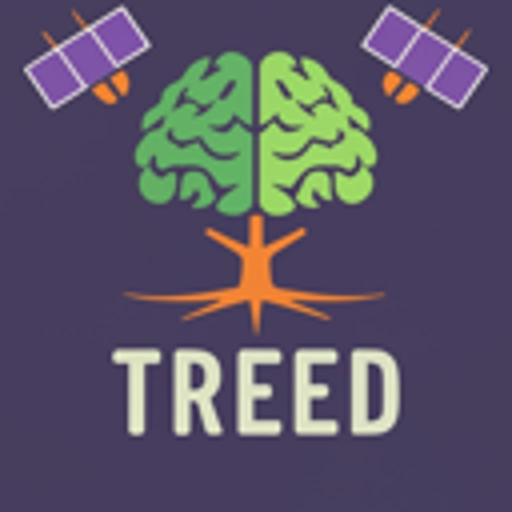

In [33]:
upscaled_multispectral_image

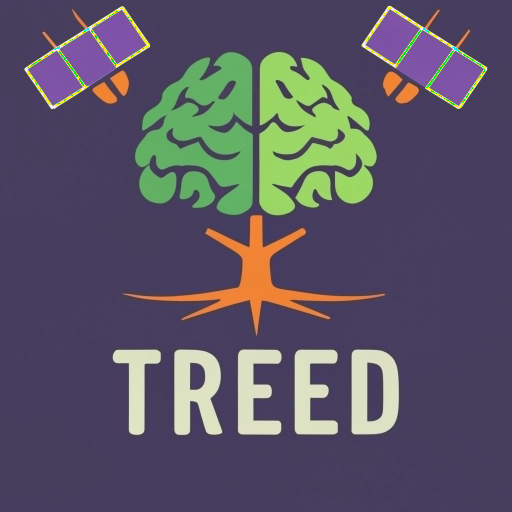

In [34]:
pansharpened_image

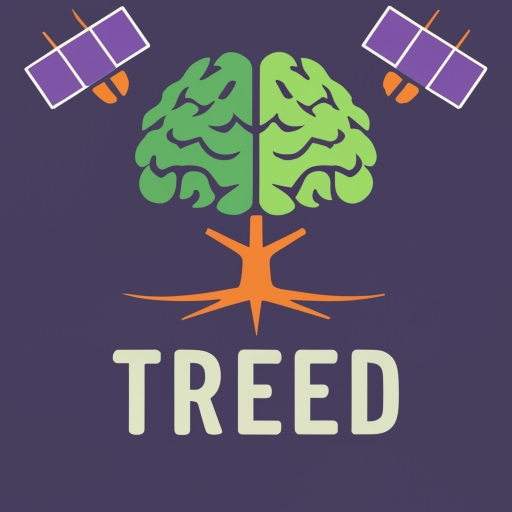

In [35]:
original_image

In [38]:
def pansharpen(panchromatic_array: np.ndarray, upscaled_multispectral_array: np.ndarray, weights: np.ndarray):
    psuedo_pan_array = np.true_divide((upscaled_multispectral_array*weights).sum(axis=2), weights.sum())
    ratio = grayscale_array/psuedo_pan_array
    new_red = upscaled_multispectral_array[:, :, 0] * ratio
    new_green = upscaled_multispectral_array[:, :, 1] * ratio
    new_blue = upscaled_multispectral_array[:, :, 2] * ratio
    pansharpened_array = np.stack([new_red, new_green, new_blue], axis=2)
    return pansharpened_array

In [39]:
pansharpen(grayscale_array, upscaled_multispectral_array, channel_dependant_luminance_perception)

array([[[73.18560683, 63.02093922, 97.58080911],
        [72.14009816, 62.12064008, 96.18679755],
        [72.14009816, 62.12064008, 96.18679755],
        ...,
        [71.14018802, 61.12044323, 95.18757552],
        [71.14018802, 61.12044323, 95.18757552],
        [71.14018802, 61.12044323, 95.18757552]],

       [[71.09458949, 61.22034095, 94.79278599],
        [72.14009816, 62.12064008, 96.18679755],
        [72.14009816, 62.12064008, 96.18679755],
        ...,
        [71.14018802, 61.12044323, 95.18757552],
        [71.14018802, 61.12044323, 95.18757552],
        [71.14018802, 61.12044323, 95.18757552]],

       [[72.14009816, 62.12064008, 96.18679755],
        [72.14009816, 62.12064008, 96.18679755],
        [72.14009816, 62.12064008, 96.18679755],
        ...,
        [71.14018802, 61.12044323, 95.18757552],
        [70.09400878, 60.22161318, 93.78775823],
        [71.14018802, 61.12044323, 95.18757552]],

       ...,

       [[70.7658483 , 61.7955295 , 92.69329425],
        [70